In [25]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from scipy import sparse
from matplotlib import pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans


In [26]:
# Reading in the data
nodes = pd.read_csv('data/nodes.txt',sep="\t", header=None)
edges = pd.read_csv('data/edges.txt',sep="\t",header=None)

In [27]:
# Data exploration and cleaning
print(nodes.isnull().values.any())
print(nodes.isnull().sum())

True
0    0
1    0
2    2
3    2
dtype: int64


In [28]:
missingRows = nodes[nodes[2].isnull()]
# Nodes 56 and 111 are missing values
print(missingRows)
# We can remove these 2 points from our dataset
print(len(nodes))
cleanNodes = nodes.dropna()
print(len(cleanNodes))


       0                                          1   2    3
55    56  atrios.blogspot.com/\t0\tLabeledManually" NaN  NaN
110  111   brunon.blogspot.com\t0\tLabeledManually" NaN  NaN
1490
1488


In [29]:
uniqueNodes = cleanNodes[0].unique()

In [30]:
cleanEdges = edges

In [31]:
# Removing the missing nodes from the edges list as well
cleanEdges = cleanEdges[(cleanEdges[0].isin(uniqueNodes)) & (cleanEdges[1].isin(uniqueNodes))]

In [32]:
len(cleanEdges)

19002

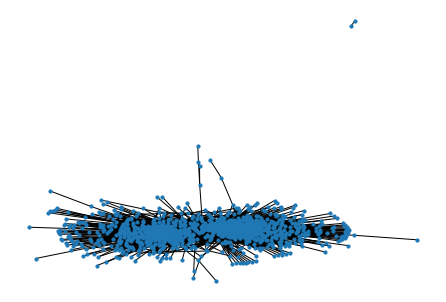

In [33]:
# Graphing the data
g_data=nx.from_pandas_edgelist(cleanEdges, 0, 1)
nx.draw(g_data, node_size = 10)    
plt.show()

In [34]:
# Finding the isolated nodes
components = list(nx.connected_components(g_data))
components.sort(key=len, reverse=True)
largest = components.pop(0)
num_isolated = g_data.order() - len(largest)
print("Number of isolated nodes = " + str(num_isolated) + " at " + str(components))

Number of isolated nodes = 2 at [{666, 182}]


In [35]:
# Removing the isloated nodes from the edgelist on the nodelist
cleanEdges2 = cleanEdges[~(cleanEdges[0].isin([182,666])) & ~(cleanEdges[1].isin([182,666]))]
cleanNodes2 = cleanNodes[~cleanNodes[0].isin([182,166])]

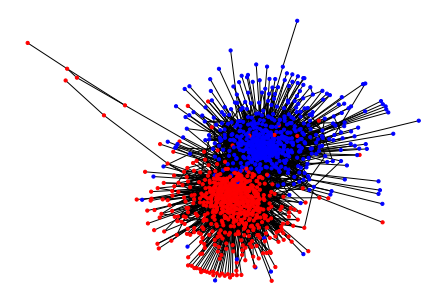

In [36]:
# Plotting a graph to show the political orientation of the blogs
g_data=nx.from_pandas_edgelist(cleanEdges2, 0, 1)
# Adding color for each orientation
colorList = []
for each in g_data:
    if int(nodes[nodes[0]==each][2]) == 0:
        colorList.append('blue')
    else:
        colorList.append('red')
nx.draw(g_data, node_size = 10,node_color=colorList)    
plt.show()

In [49]:
# Beginning the spectral clustering algorithm
k = 2
n = max(cleanEdges2[0])
a = np.array(cleanEdges2)

In [50]:
i = a[:, 0]-1
j = a[:, 1]-1
v = np.ones((a.shape[0], 1)).flatten()

A = sparse.coo_matrix((v, (i, j)), shape=(n, n))
A = (A + np.transpose(A))/2

In [51]:
# M = A[A.getnnz(1)>0][:,A.getnnz(0)>0]
M = A

In [52]:
D = np.diag(1/np.sqrt(np.sum(M, axis=1)).A1)
# L = D @ M @ D
# D = np.diag(np.sum(M, axis=1))
L = D - M
L = np.nan_to_num(L)
print(D)
v, x = np.linalg.eig(L)
x = x[:, 0:k].real
copyx = x
# x = np.squeeze(np.asarray(x))
# x = x/np.repeat(np.sqrt(np.sum(x*x, axis=1).reshape(-1, 1)), k, axis=1)

# scatter
# plt.scatter(x[:, 0], x[:, 1])
# plt.show()

/Users/ajspsp/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


[[0.27216553 0.         0.         ... 0.         0.         0.        ]
 [0.         0.20412415 0.         ... 0.         0.         0.        ]
 [0.         0.                inf ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.41421356 0.         0.        ]
 [0.         0.         0.         ... 0.         0.30151134 0.        ]
 [0.         0.         0.         ... 0.         0.         1.41421356]]


In [53]:
kmeans = KMeans(n_clusters=2).fit(copyx)
idx = kmeans.labels_

df = nodes.copy()

In [54]:
df['Predicted'] = idx
predictedNodes = df.dropna()

/Users/ajspsp/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


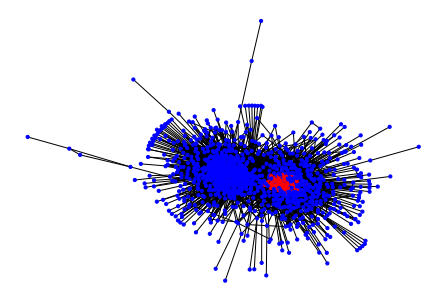

In [55]:
# Plotting a graph to show the political orientation of the blogs from the predicted values
predictedData=nx.from_pandas_edgelist(cleanEdges2, 0, 1)
# Adding color for each orientation
predictedcolorList = []

for each in predictedData:
    if (df[df[0]==each]['Predicted'].values[0]) == 0:
        predictedcolorList.append('blue')
    else:
        predictedcolorList.append('red')
nx.draw(predictedData, node_size = 10,node_color=predictedcolorList)    
plt.show()

In [56]:
# Making the dataframe for the predicted values
predictedDf = df.copy()
predictedDf = predictedDf.dropna()
predictedDf = predictedDf[~predictedDf[0].isin([182,166])]

predictedDf['Accuracy'] = ((predictedDf[2].astype(int)) == predictedDf['Predicted'])
accuracy = sum(predictedDf['Accuracy']/len(predictedDf))
print('The accuracy of the spectral clustering algorithm is {:.2%}'.format(accuracy))

The accuracy of the spectral clustering algorithm is 42.73%
